In [1]:
import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import normalized_mutual_info_score
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import *
from cVAE_utils import *
from cVAE_trainer import *

/afs/inf.ed.ac.uk/user/s24/s2442138/miniconda3/envs/ConGele/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/afs/inf.ed.ac.uk/user/s24/s2442138/miniconda3/envs/ConGele/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/afs/inf.ed.ac.uk/user

# Load the model

In [2]:
model_info_dir = "./3DcVAE_asd-UKBB604-dim32/3-RAE-ALL-train_480-val_120-HP-alpha_250000-beta_1-gamma_0.01-batch_size_10"

norm_type = "min-max-4"

salient_dim=32
irrelevant_dim=32

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [4]:
## normally:
model_path = os.path.join(model_info_dir, "model_best.pth")

## some test case:
# model_path = "./3DcVAE_asd-UKBB604-dim32/ALL-train_480-val_120-HP-alpha_250000-beta_1-gamma_100-batch_size_10/model_best - 085 - -0.063.pth"
# model_path = os.path.join(model_info_dir, "model_last.pth")

cVAE = ContrastiveVAE(salient_dim=salient_dim, irrelevant_dim=irrelevant_dim, model_type="asd")
cVAE = torch.nn.DataParallel(cVAE)
cVAE = cVAE.to(device)

state_dict = torch.load(model_path)
cVAE.load_state_dict(state_dict['model'])

<All keys matched successfully>

## get salient encoder

In [5]:
salient_encoder = cVAE.module.get_salient_encoder()
salient_encoder = torch.nn.DataParallel(salient_encoder)
salient_encoder = salient_encoder.to(device)
summary(salient_encoder, input_size=(1, 1, 160, 192, 160))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [1, 32]                   --
├─cVAE_encoder_asd: 1-1                  [1, 32]                   40,493,504
├─cVAE_encoder_asd: 1-2                  --                        --
│    └─Sequential: 2-1                   [1, 32, 80, 96, 80]       960
│    └─Sequential: 2-2                   --                        --
│    │    └─Conv3d: 3-1                  [1, 32, 80, 96, 80]       896
│    │    └─BatchNorm3d: 3-2             [1, 32, 80, 96, 80]       64
│    │    └─ReLU: 3-3                    [1, 32, 80, 96, 80]       --
│    └─Sequential: 2-3                   [1, 64, 40, 48, 40]       55,488
│    └─Sequential: 2-4                   --                        --
│    │    └─Conv3d: 3-4                  [1, 64, 40, 48, 40]       55,360
│    │    └─BatchNorm3d: 3-5             [1, 64, 40, 48, 40]       128
│    │    └─ReLU: 3-6                    [1, 64, 40, 48, 40]      

# Prepare test set

In [6]:
## all HC, MDD, diabetes, mdd_diabetes

HC_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/HC_info.csv")
HC_info.set_index("f.eid", inplace=True)
HC_ids_all = set(HC_info.index.tolist())
print(len(HC_ids_all))

MDD_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/MDD_info.csv")
MDD_info.set_index("f.eid", inplace=True)
MDD_ids_all = set(MDD_info.index.tolist())
print(len(MDD_ids_all))

diabetes_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/diabetes_info.csv")
diabetes_info.set_index("f.eid", inplace=True)
diabetes_ids_all = set(diabetes_info.index.tolist())
print(len(diabetes_ids_all))

mdd_diabetes_info = pd.read_csv("./data_info/T1_MNI_20252_2_0/mdd_diabetes_info.csv")
mdd_diabetes_info.set_index("f.eid", inplace=True)
mdd_diabetes_ids_all = set(mdd_diabetes_info.index.tolist())
print(len(mdd_diabetes_ids_all))

## used in training / val

bg_dataset = pd.read_csv("./data_info/T1_MNI_20252_2_0/all3_HC/bg_dataset_604.csv")
bg_dataset.set_index("f.eid", inplace=True)
HC_ids_train = set(bg_dataset.index.tolist())
print(len(HC_ids_train))

tg_dataset = pd.read_csv("./data_info/T1_MNI_20252_2_0/all3_HC/tg_dataset_604.csv")
tg_dataset.set_index("f.eid", inplace=True)

MDD_ids_train = set(tg_dataset[tg_dataset["status"]=="mdd"].index.tolist())
print(len(MDD_ids_train))

diabetes_ids_train = set(tg_dataset[tg_dataset["status"]=="diabetes"].index.tolist())
print(len(diabetes_ids_train))

mdd_diabetes_ids_train = set(tg_dataset[tg_dataset["status"]=="mdd_diabetes"].index.tolist())
print(len(mdd_diabetes_ids_train))

6802
2461
349
137
604
307
211
86


In [7]:
## data for testing
HC_ids_test = HC_ids_all - HC_ids_train
HC_test = HC_info.loc[list(HC_ids_test)]
print(len(HC_test))

MDD_ids_test = MDD_ids_all - MDD_ids_train
MDD_test = MDD_info.loc[list(MDD_ids_test)]
print(len(MDD_test))

diabetes_ids_test = diabetes_ids_all - diabetes_ids_train
diabetes_test = diabetes_info.loc[list(diabetes_ids_test)]
print(len(diabetes_test))

mdd_diabetes_ids_test = mdd_diabetes_ids_all - mdd_diabetes_ids_train
mdd_diabetes_test = mdd_diabetes_info.loc[list(mdd_diabetes_ids_test)]
print(len(mdd_diabetes_test))

6198
2154
138
51


In [8]:
random_state = 77
n_test = 40

HC_test_rand = HC_test.sample(n=n_test, random_state=random_state)
MDD_test_rand = MDD_test.sample(n=n_test, random_state=random_state)
diabetes_test_rand = diabetes_test.sample(n=n_test, random_state=random_state)
mdd_diabetes_test_rand = mdd_diabetes_test.sample(n=n_test, random_state=random_state)

test_rand_all = pd.concat([HC_test_rand, MDD_test_rand, diabetes_test_rand, mdd_diabetes_test_rand])
print(len(test_rand_all))

all_test_paths = test_rand_all["path"].tolist()
all_test_labels = test_rand_all["label"].tolist()
print(len(all_test_paths))
print(len(all_test_labels))

160
160
160


In [9]:
batch_size = 10

all_test_loader = DataLoader(
        ConcatDataset(test_rand_all["path"].tolist(), test_rand_all["label"].tolist()),
        batch_size=batch_size, shuffle=False, num_workers=3)

# for batch, (paths, labels) in enumerate(all_test_loader):
#     print(labels)

# Infer salient features

In [10]:
def infer_salient_features(dataloader, encoder, norm_type, model_info_dir, device, enlarge=0.1):
    encoder.eval()
    s_mu_list = []
    label_list = []

    # get normalization parameters
    norm_params=get_normalization_params(model_info_dir=model_info_dir, type=norm_type)

    with torch.no_grad():
        for batch, (paths, labels) in enumerate(tqdm(dataloader)):
        # for batch, (paths, labels) in enumerate(dataloader):
            # obtain np array from path list
            X_arr = create_dataset_from_nii_path_list(paths)
            # normalizing inputs
            X_arr, _ = apply_normalization(type=norm_type, params=norm_params,
                                                     tg_samples=X_arr, bg_samples=np.array([0]), enlarge=enlarge)
            # convert to tensor
            X = torch.from_numpy(X_arr)
            # convert data to float type and move it to cuda
            X = X.type(torch.FloatTensor).to(device)

            # get inference result
            s_mu, _, _, = salient_encoder(X)

            s_mu_list.append(s_mu)
            label_list.extend(labels.tolist())

    # calculate silhouette score
    s_mu = torch.vstack(s_mu_list).cpu()
    print(s_mu.shape)
    ss = -77777
    if len(set(label_list))>1:
        ss = silhouette_score(s_mu, label_list)

    # plot
    plot_latent_features_2D(mu=s_mu, label=label_list, ss=ss, loss=-77777, name='salient')

    return s_mu.numpy(), label_list

100%|███████████████████████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.16s/it]


torch.Size([160, 32])


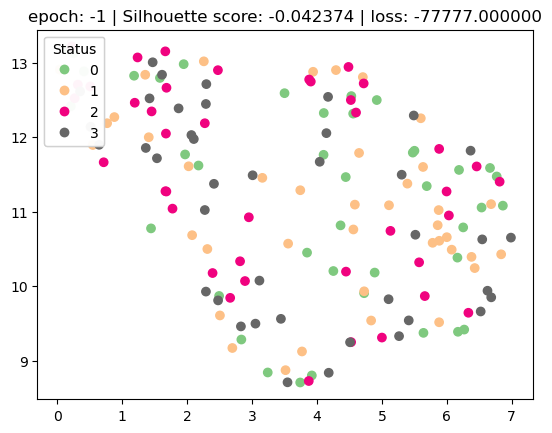

In [11]:
features, labels = infer_salient_features(dataloader=all_test_loader, encoder=salient_encoder, 
                                          norm_type=norm_type, 
                                          model_info_dir=model_info_dir, device=device)

In [12]:
print(features.shape)
print(len(labels))
print(labels)

(160, 32)
160
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


# Plot

In [13]:
reducer = umap.UMAP()
features_2D = reducer.fit_transform(features)

In [14]:
HC_2D = features_2D[:40]
MDD_2D = features_2D[40:80]
diabetes_2D = features_2D[80:120]
dual_2D = features_2D[120:]

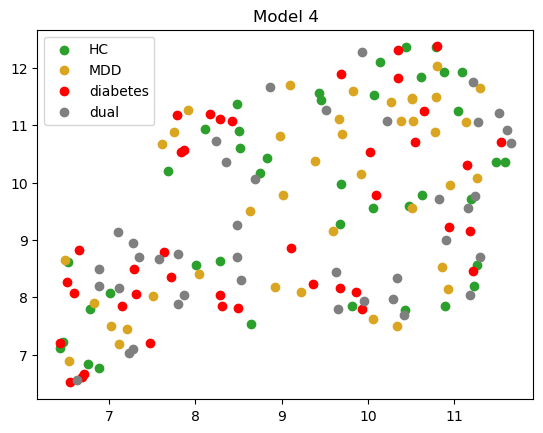

In [15]:
plt.scatter(HC_2D[:, 0], HC_2D[:, 1], label="HC", color="C2")
plt.scatter(MDD_2D[:, 0], MDD_2D[:, 1], label="MDD", color="goldenrod")
plt.scatter(diabetes_2D[:, 0], diabetes_2D[:, 1], label="diabetes", color="red")
plt.scatter(dual_2D[:, 0], dual_2D[:, 1], label="dual", color="C7")
plt.legend()
plt.title("Model 4")
plt.savefig("./analysis/test-4-plot")

# SS

In [16]:
ss = silhouette_score(features[40:], labels[40:])
ss

-0.028301597

# NMI

In [17]:
## target
NMI_list=[]
cycle=100

for i in range(cycle):
    k = 3
    gmm0 = GaussianMixture(n_components=k, init_params='kmeans')
    labels_gmm = gmm0.fit_predict(features[40:])
    NMI =  normalized_mutual_info_score(labels[40:], labels_gmm)
    NMI_list.append(NMI)

print(NMI_list)
print(np.array(NMI_list).mean())

[0.020765947877042404, 0.020765947877042404, 0.00724386182732491, 0.015528653238522643, 0.020765947877042404, 0.014969355993953484, 0.014315706422815275, 0.014969355993953487, 0.014724126211255075, 0.013733823445888114, 0.018565779978654738, 0.014969355993953484, 0.014315706422815272, 0.013091465113682895, 0.016608291193550083, 0.029593542779450935, 0.020765947877042404, 0.014620196281443187, 0.014620196281443183, 0.023193903556143366, 0.016608291193550083, 0.020765947877042404, 0.03137537279649512, 0.014969355993953487, 0.014620196281443183, 0.0223385274036399, 0.022047589461380027, 0.016608291193550083, 0.016001404096803333, 0.021171775930824456, 0.01754064648304181, 0.016608291193550083, 0.020765947877042404, 0.016130321862170314, 0.014315706422815272, 0.016608291193550083, 0.01402342342301045, 0.013737556583463408, 0.02633538422402503, 0.017898275658484786, 0.014620196281443187, 0.02378757781940482, 0.01454015279638875, 0.012821300465866678, 0.022047589461380027, 0.0126103689401192

In [18]:
## all
NMI_list=[]
cycle=100

for i in range(cycle):
    k = 3
    gmm0 = GaussianMixture(n_components=k, init_params='kmeans')
    labels_gmm = gmm0.fit_predict(features)
    NMI =  normalized_mutual_info_score(labels, labels_gmm)
    NMI_list.append(NMI)

print(NMI_list)
print(np.array(NMI_list).mean())

[0.011536861871054564, 0.017369805708313778, 0.014453143072528391, 0.015254834824752426, 0.022256193586465446, 0.02639124493875533, 0.017369805708313778, 0.017374793506377523, 0.01912026531998645, 0.011536861871054564, 0.017369805708313778, 0.0399250369167407, 0.010700920098192736, 0.017860271664474583, 0.010700920098192736, 0.015402021773670834, 0.010700920098192736, 0.010700920098192736, 0.010124666531480158, 0.012126855052651934, 0.014453143072528391, 0.017369805708313778, 0.0054632554731546806, 0.022256193586465446, 0.009195577256208306, 0.02496707213052921, 0.022256193586465446, 0.017860271664474583, 0.015546355844093957, 0.017860271664474583, 0.028100591429982374, 0.015402021773670834, 0.024016387431133428, 0.010700920098192736, 0.017369805708313778, 0.015402021773670834, 0.015068949189150103, 0.017369805708313778, 0.011536861871054564, 0.01916457319015036, 0.02921435851976239, 0.006469387862698677, 0.015402021773670834, 0.017369805708313778, 0.009334687573396193, 0.0222561935864